In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02a_machine_perception.ipynb"
_nb_title = "Flowers Image Classification using a linear model"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Flowers+Image+Classification+using+a+linear+model&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 線形モデルを使用した花の画像分類  

以下の5つのカテゴリに分類される3670枚のクリエイティブコモンズライセンスの[花の写真データセット](https://www.tensorflow.org/datasets/catalog/tf_flowers)を使用します。  
- ヒナギク(daisy)
- バラ(roses)
- タンポポ(dandelion)
- ヒマワリ(sunflowers)
- チューリップ(tulips)


画像は、パブリックバケットのGoogle Cloud Storage にすでに準備されています。  
<pre>  
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/
</pre>  

画像は、データのうち90％を含む学習用データセットと10％を含む評価用データセットにランダムに分割されており、それぞれCSVファイルにリストされています。

学習用データセット：[train_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)  
評価用データセット：[eval_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv)  


## GPUを有効にする  

GPUを使用していれば、このノートブックを含むリポジトリ内のほとんどすべてのノートブックをより高速に実行することができます。

Colabの場合:
- [編集]→[ノートブック設定]へ移動
- [ハードウェアアクセラレータ]ドロップダウンから[GPU]を選択

Vertex AI の場合:
- https://console.cloud.google.com/vertex-ai/workbench/list/instances へ移動
- GPUを使用してインスタンスを作成するか、インスタンスを選択してGPUを追加します  

次に、Tensorflowを使用してGPUに接続できることを確認します。

In [23]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.2
Found GPU at: /device:GPU:0


2021-12-17 05:42:48.618148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:42:48.618631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:42:48.618916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:42:48.619428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 05:42:48.619745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## 画像を調査する

train_set.csvの最初の5行を見てみましょう。  
各行はJPEGファイル名と花の種類で構成されていることが分かります。

In [24]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

In [25]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # ファイルを読み込む
  img = tf.io.read_file(filename)
  # 圧縮された文字列を3次元のuint8のテンソルに変換する
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # 3次元のuint8を[0, 1]の範囲の浮動小数点数に変換する
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 画像を必要なサイズにリサイズする
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


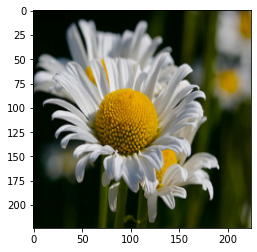

In [27]:
# ファイルを一つ読み込み、可視化してみる
def show_image(filename):
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


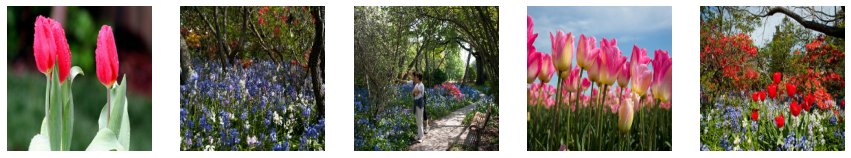

In [28]:
# ファイル名に花の種類のデータが含まれていることに注目してみましょう。いくつか可視化してみます。
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
    print(filename)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    ax[idx].imshow((img.numpy()));
    ax[idx].axis('off')

In [29]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

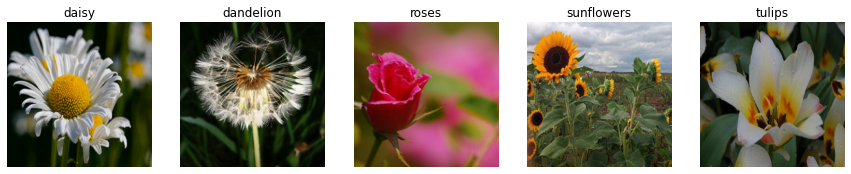

In [30]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title(CLASS_NAMES[idx])
    ax[idx].axis('off')

## シンプルなルールベースモデル  

まずは、それぞれの花のRGB値の平均色を取得し、未知の画像は最も近い色のものに属するとして分類してみましょう。

In [31]:
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    # label = tf.math.equal(CLASS_NAMES, label_string)
    return img, label_string

dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
    avg = tf.math.reduce_mean(img, axis=[0, 1]) # 画像の平均的なピクセルを求める
    print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


花の種類ごとに約800枚の画像があるため、すべての画像を実行するとしばらく時間がかかります。こうした処理を高速化する方法については、本書の後半で説明します。

In [32]:
class Centroid:
    def __init__(self, label):
        self.label = label
        self.sum_so_far = tf.constant(0., dtype=tf.float32)
        self.count_so_far = 0
  
    def update(self, value):
        self.sum_so_far = self.sum_so_far + value
        self.count_so_far = self.count_so_far + 1
        if self.count_so_far%100 == 0:
            print(self.label, self.count_so_far)

    def centroid(self):
        return self.sum_so_far / self.count_so_far

    def __str__(self):
        return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
    def __init__(self):
        self.centroids = {
          f: Centroid(f) for f in CLASS_NAMES}

    def fit(self, dataset):
        for img, label in dataset:
            label = label.numpy().decode("utf-8")
            avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
            self.centroids[label].update(avg)
  
    def predict(self, img):
        avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
        best_label = ""
        best_diff = 999
        for key, val in self.centroids.items():
            diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
            if diff < best_diff:
                best_diff = best_diff
                best_label = key
        return best_label
  
    def evaluate(self, dataset):
        num_correct, total_images = 0, 0
        for img, label in dataset:
            correct = label.numpy().decode('utf-8')
            predicted = self.predict(img)
            if correct == predicted:
                num_correct = num_correct + 1
        total_images = total_images + 1
        accuracy = num_correct / total_images
        return(accuracy)

In [33]:
rule = CentroidRule()

# すべてのデータセットで試したい場合、`.take(500)` を削除してください
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# 異なったクラスの間に、顕著な違いは見られません
print(rule.centroids['daisy'])
print(rule.centroids['roses'])

# では、評価してみましょう
rule.evaluate(eval_dataset)

dandelion 100
tulips 100
daisy [0.44554377 0.44968468 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

このルールでは、ほとんどランダムな推測にしかならないことが分かります。

In [35]:
# 以下で推論を行うことができます
filename = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

tulips


## 線形モデル  
ピクセルごとに異なる重みを適用するとどうなるでしょうか？  
Keras API を使用して線形モデルを作成してみましょう。

In [40]:
# `CLASS_NAMES`列がラベルのインデックスになるように decode_csv 関数を変更
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

# 線形モデル
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


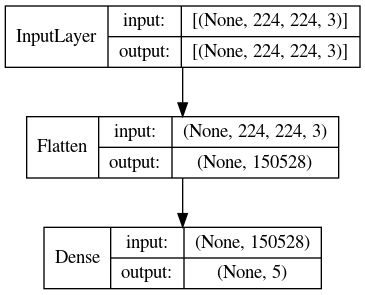

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [43]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 185s 559ms/step - loss: 18.1229 - accuracy: 0.3376 - val_loss: 24.0965 - val_accuracy: 0.3216
Epoch 2/10
330/330 [==============================] - 94s 284ms/step - loss: 15.6027 - accuracy: 0.4045 - val_loss: 27.5600 - val_accuracy: 0.3865
Epoch 3/10
330/330 [==============================] - 90s 273ms/step - loss: 15.0241 - accuracy: 0.4455 - val_loss: 19.8729 - val_accuracy: 0.3946
Epoch 4/10
330/330 [==============================] - 81s 245ms/step - loss: 14.8788 - accuracy: 0.4679 - val_loss: 32.5431 - val_accuracy: 0.3757
Epoch 5/10
330/330 [==============================] - 80s 243ms/step - loss: 16.2751 - accuracy: 0.4779 - val_loss: 29.3768 - val_accuracy: 0.3541
Epoch 6/10
330/330 [==============================] - 81s 244ms/step - loss: 15.9308 - accuracy: 0.4961 - val_loss: 26.9881 - val_accuracy: 0.3676
Epoch 7/10
330/330 [==============================] - 82s 247ms/step - loss: 10.7865 - accuracy: 0.5752 - val_loss: 1

In [44]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

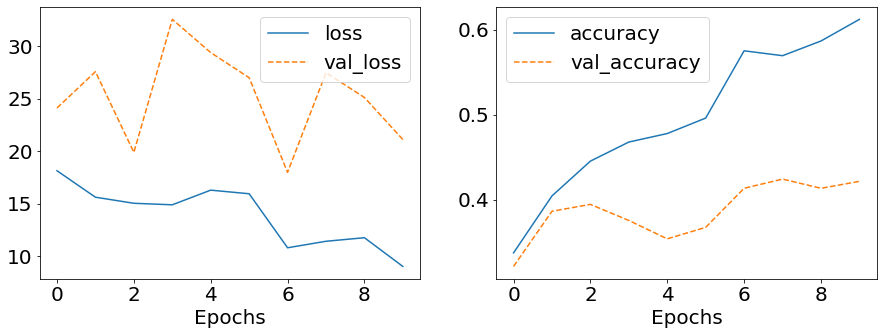

In [45]:
training_plot(['loss', 'accuracy'], history);

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.0721875  0.8794238 ]


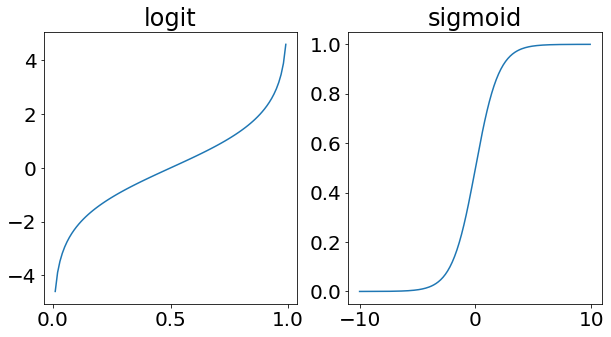

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

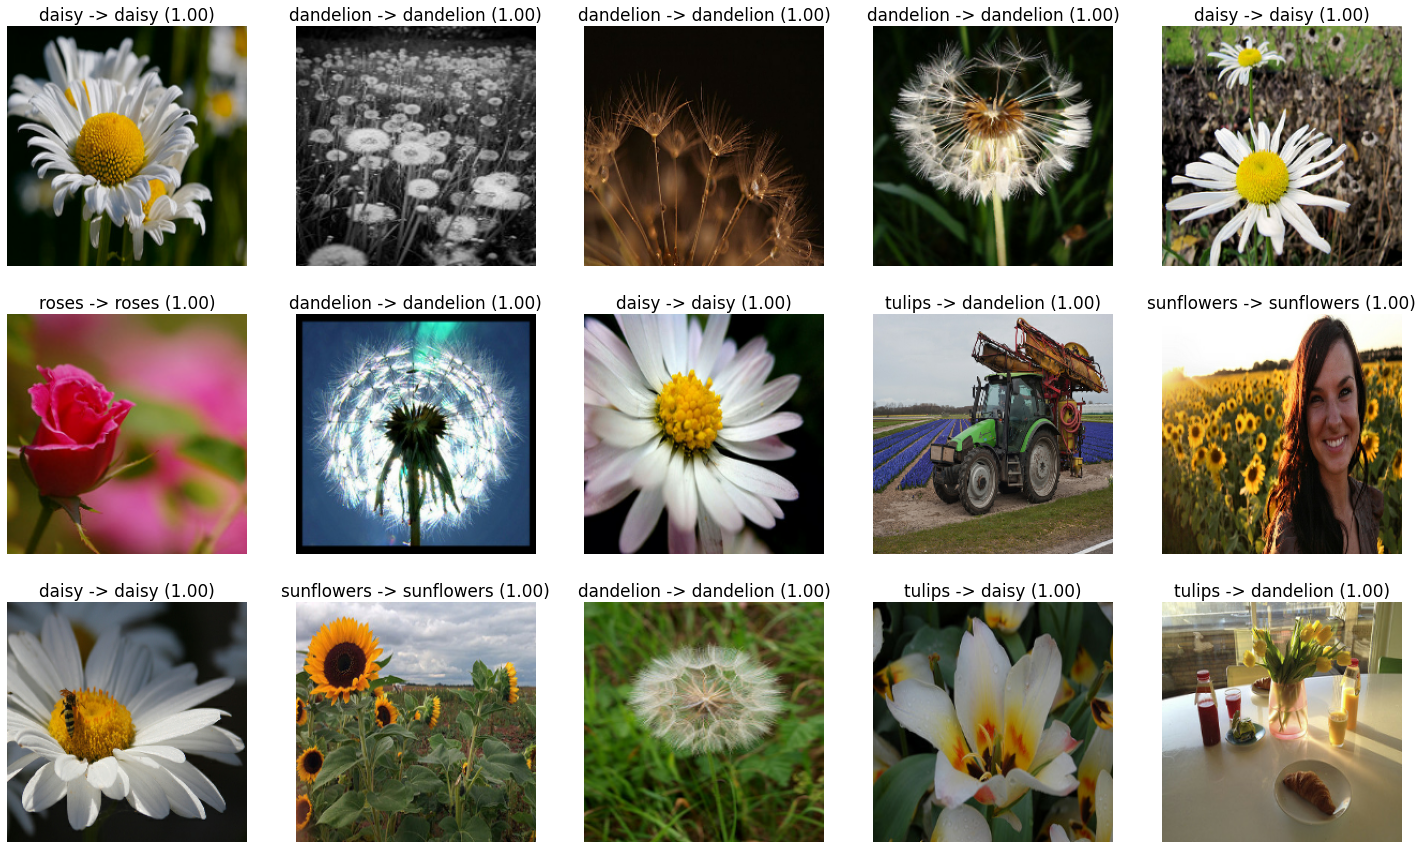

In [47]:
# 検証用データセットからいくつかの画像を model.predict() で推論
def plot_predictions(filename):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
        ax[idx//5, idx%5].axis('off')

plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

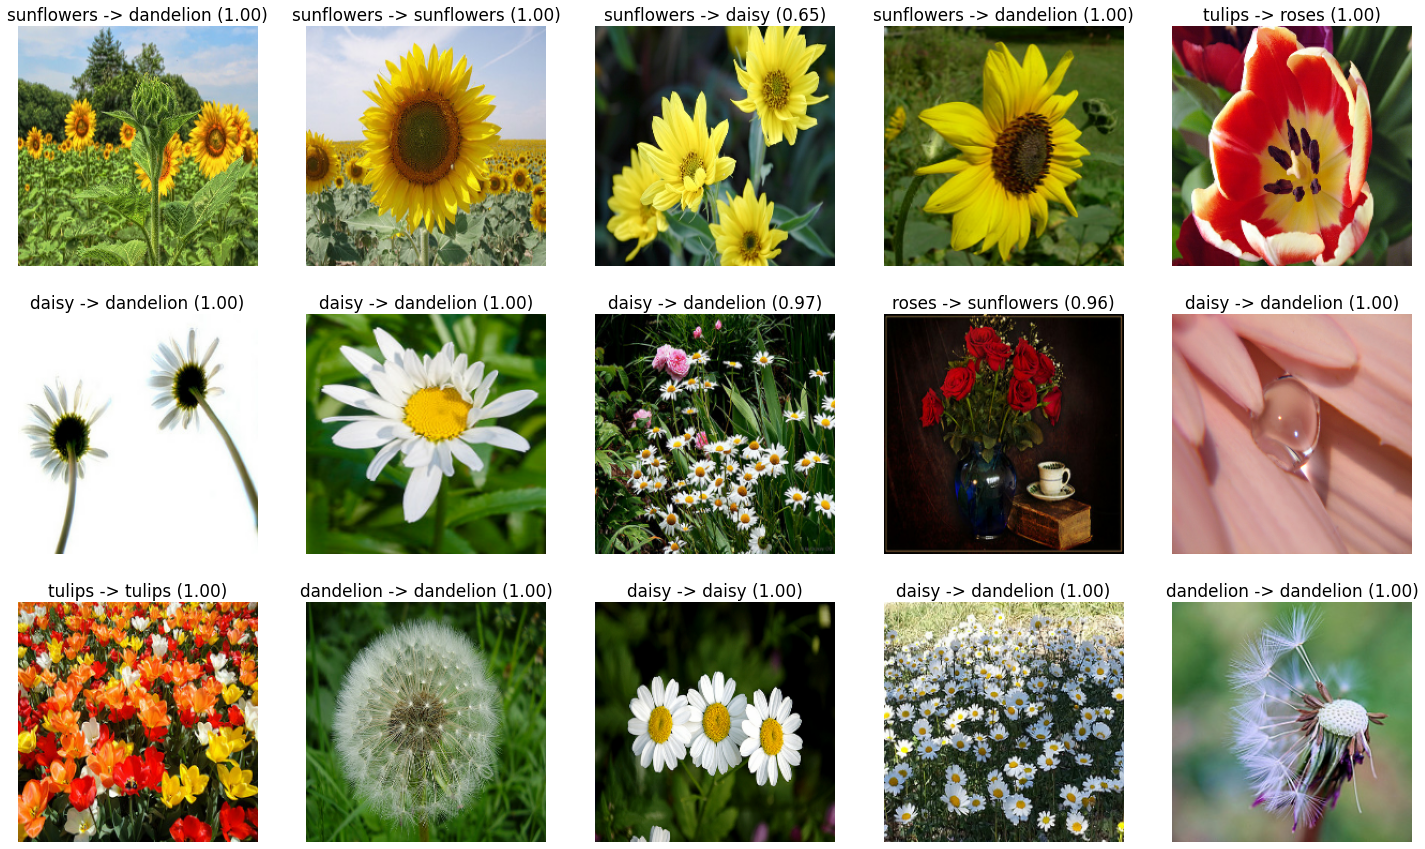

In [48]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

Scaling weights for daisy in -0.12986034154891968 to 0.11869979649782181
Scaling weights for dandelion in -0.11060556024312973 to 0.13644635677337646
Scaling weights for roses in -0.10866878181695938 to 0.11435676366090775
Scaling weights for sunflowers in -0.15951970219612122 to 0.1273648887872696
Scaling weights for tulips in -0.10902760922908783 to 0.11049680411815643


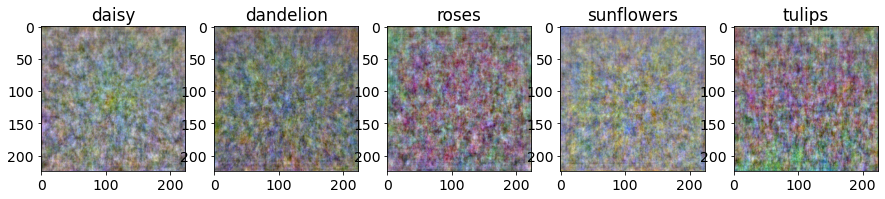

In [49]:
def show_trained_weights(model):
    # CLASS_NAMES: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    LAYER = 1 # Layer = 0 は平坦化層(Flatten)、 Layer = 1 が最初の全結合層(Dense)
    WEIGHT_TYPE = 0 # 0 は重み(weight), 1 はバイアス(bias)

    f, ax = plt.subplots(1, 5, figsize=(15,15))
    for flower in range(len(CLASS_NAMES)):
        weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
        min_wt = tf.math.reduce_min(weights).numpy()
        max_wt = tf.math.reduce_max(weights).numpy()
        flower_name = CLASS_NAMES[flower]
        print("Scaling weights for {} in {} to {}".format(
            flower_name, min_wt, max_wt))
        weights = (weights - min_wt)/(max_wt - min_wt)
        ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
        ax[flower].set_title(flower_name);

show_trained_weights(model)

## ダイアグラム  

これらでは本書の中で使用された図をプロットします。

[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.        0.2       0.6000001 0.2       0.       ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


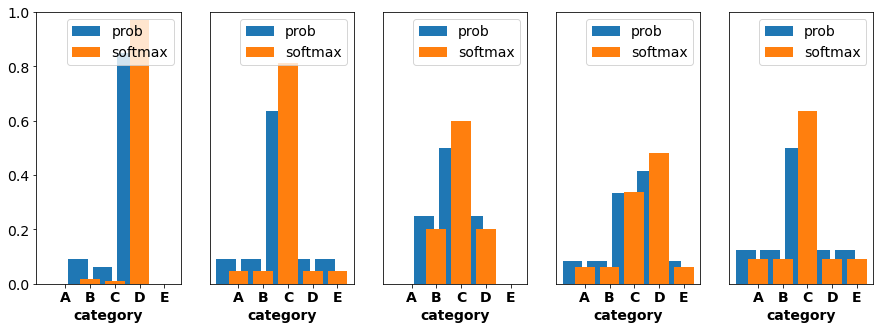

In [50]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.